### Import packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from pandas import Series, DataFrame
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

In [4]:
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sns.set_style("whitegrid")

### Import Data

In [7]:
titanic = pd.read_csv("data/titanic-train.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Exploratory data analysis

In [8]:
titanic.shape

(891, 12)

* `survived` : 0 = no, 1 = yes
* `Pclass` passenger class (1=1st, 2=2nd, 3=3rd)
* `Name` : name of passanger
* `Sex`
* `Age`
* `SibSp` : number of siblings/spouse aboard
* `Parch` : Number of parents/children aboard
* `Ticket` : ticket number
* `Fare` : passenger fare in pound
* `Cabin` : cabin number
* `Embarked` : Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

#### Check whether target variable is binary
* We are predicting survival of the passengers, target variable is `Survived`

In [10]:
titanic.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


* Ok, so we are working with binary classification problem

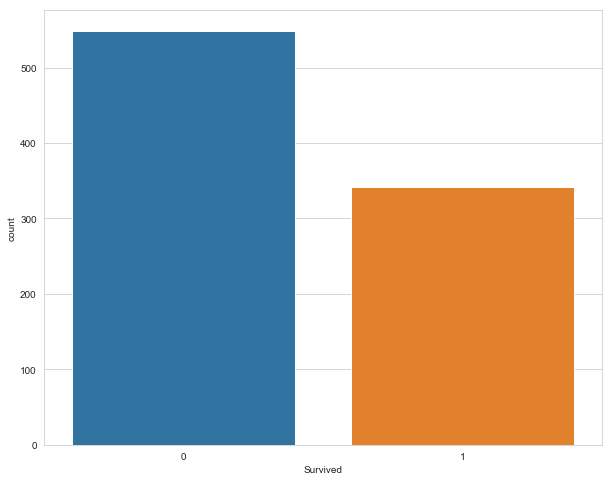

In [11]:
sns.countplot(x="Survived", data=titanic)

### Handling missing data

In [12]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [13]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


* Ok, so there are 891 in titanic dataframe, cabin is almost all missing values we can drop it. Age also has missing values, but also it may be good predictor for survival, we will need to handle it.
* Also name, ticket number and passanger ID seems not useful let's get rid of them too

In [14]:
titanic = titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [15]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


#### Imputing missing values for Age
* We explore how age is related to class

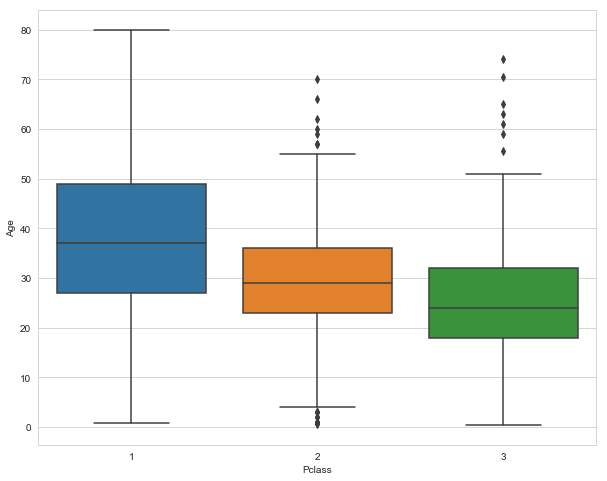

In [16]:
sns.boxplot(x='Pclass', y='Age', data=titanic)

In [17]:
titanic.groupby('Pclass')['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

* Looks like old people are traveling in first class. Young people are in third class.

In [18]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 38
        elif Pclass == 2:
            return 30
        else:
            return 25
    else:
        return Age

In [19]:
titanic['Age']  = titanic[['Age', 'Pclass']].apply(age_approx, axis=1)

In [20]:
titanic.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

* There are 2 null values in embarked, we can drop those 2 records without losing too much info.

In [21]:
titanic.dropna(inplace=True)

In [22]:
titanic.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

### Convert categorical values in dummy indicators
* We need to convert sex and Embarked variable to numerical variable.

In [23]:
gender = pd.get_dummies(titanic['Sex'], drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [24]:
embark_location = pd.get_dummies(titanic["Embarked"], drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [25]:
titanic.drop(['Sex', 'Embarked'], axis=1, inplace=True)

In [26]:
titanic = pd.concat([titanic, gender, embark_location], axis = 1)

In [27]:
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


### Check for correlation

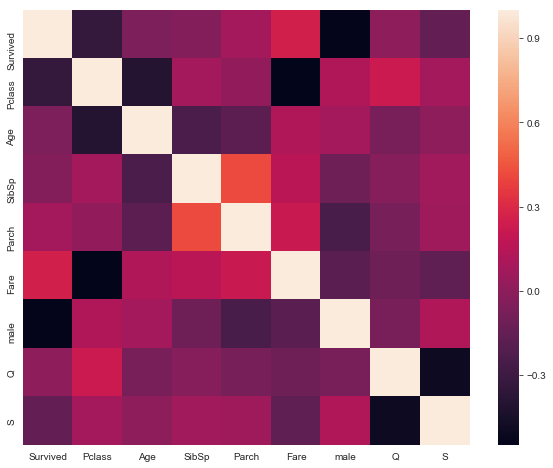

In [29]:
sns.heatmap(titanic.corr())

* Fare and Pclass has high negative correlation, we can drop Fare feature.

In [30]:
titanic.drop(['Fare'], axis=1, inplace=True)

In [31]:
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,male,Q,S
0,0,3,22.0,1,0,1,0,1
1,1,1,38.0,1,0,0,0,0
2,1,3,26.0,0,0,0,0,1
3,1,1,35.0,1,0,0,0,1
4,0,3,35.0,0,0,1,0,1


### Checking that dataset size is sufficient
* We have 6 predictive features. The rule of thumb is 50 records per features, so we need at least 300 records in dataset, and we have more than that. So, we are fine.

### Model creation

In [41]:
X = titanic.iloc[:, 1:]
y = titanic.iloc[:, 0]

In [42]:
X.shape

(889, 7)

In [43]:
y.shape

(889,)

In [44]:
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
X_train.shape

(622, 7)

In [46]:
y_train.shape

(622,)

In [47]:
X_test.shape

(267, 7)

In [48]:
y_test.shape

(267,)

In [49]:
LogReg = LogisticRegression(penalty="l1")

In [50]:
LogReg.fit(X_train,y_train)

C:\Users\davep\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
LogReg.coef_

array([[-1.14278015, -0.0451724 , -0.37702048,  0.        , -2.60215511,
        -0.13331059, -0.43104895]])

In [52]:
LogReg.intercept_

array([5.57526608])

In [53]:
y_pred = LogReg.predict(X_test)

In [55]:
y_pred[0:5]

array([0, 1, 1, 0, 1], dtype=int64)

In [56]:
y_prob = LogReg.predict_proba(X_test)

In [57]:
y_prob[:5]

array([[0.89577205, 0.10422795],
       [0.04778847, 0.95221153],
       [0.24278122, 0.75721878],
       [0.75001088, 0.24998912],
       [0.03960711, 0.96039289]])

### Model Accuracy

In [58]:
from sklearn.metrics import confusion_matrix

In [59]:
confusion_matrix = confusion_matrix(y_test, y_pred)

In [60]:
confusion_matrix

array([[137,  30],
       [ 25,  75]], dtype=int64)

In [61]:
y_test.sum() 

100

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       167
           1       0.71      0.75      0.73       100

   micro avg       0.79      0.79      0.79       267
   macro avg       0.78      0.79      0.78       267
weighted avg       0.80      0.79      0.79       267



In [65]:
LogReg.score(X_test, y_test)

0.7940074906367042